The City of Chicago has made it's police database available from it's city data hub.

I'm curious about what it shows about accidents involving bicycles and, specifically, what happened during covid.

Allegedly, more people started biking in 2020 because public transit was either limited or perceived to be unsafe; many bike shops reported they couldn't keep up with demand (with supply chain problems doubtless contributing to the problem).

But drivers -- taking advantage of fewer cars on the road -- allegedly began to drive faster and more recklessly.

Questions:
    1) Was there an increase in the amount of bicycling being done during 2020? This question is better answered by analyzing DIVVY data. This cannot show how private bike use changed, but it can show whether there was an uptick in the amount of useage with the DIVVY system.
    2) Was there an increase in the number of bike accidents in 2020? This might suggest either/both more bikes on the road and/or more reckless driving being done.

To access the Chicago databases, one needs an API app token. One needs to create an account on their website (https://data.cityofchicago.org/login) and then go to the developer settings page (https://data.cityofchicago.org/profile/edit/developer_settings)

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from sodapy import Socrata

In [3]:
# get API tokens
with open('.env.development') as f:
    data = f.read()

for line in data.split('\n'):
    head,sep,tail = line.partition(' = ')
    
    if head == 'crashAPIkey':
        crashAPIkey = tail
    elif head == 'weatherAPIkey':
        weatherAPIkey = tail

One can query the city's database with a URL like this one:
    url= "https://data.cityofchicago.org/resource/85ca-t3if.json?$$app_token=AppTok$where=crash_date%20between$20'2021-01-01T00:00:00'%20and%20'2022-01-01T00:00:00'"

but it is clearer to use the Socrata client and sodapy. The syntax for it is a little confusing and the next few cells show my trial- and error-efforts to get the syntax correct.

One problem is that the URL method returns a JSON object, which Pandas does a better job of turning into a DF: numbers are recognized as numbers, mostly.

The Socrata client returns a list/dictionary and Pandas turns all the fields into string objects.

In [4]:
client=Socrata('data.cityofchicago.org',crashAPIkey)
# chicago data, App_token


In [ ]:
#results=client.get('85ca-t3if',limit=2000)
# this works - pulls 2K crash records
#len(results)

In [15]:
#results2 = client.get('85ca-t3if',where="first_crash_type== 'PEDALCYCLIST'",limit=2000)
#len(results2)

2000

In [14]:
#results3 = client.get('85ca-t3if',where= "crash_date>'21-01-01T00:00:00'",limit=2000)
#len(results3)

2000

The above cells are my experiments to get the syntax of the query correct. The documentation isn't terribly helpful about how to format the "where" statement. What I found was:

* field names don't need to be in quotes but the criteria do:
    * `first_crash_type` (field name) `== 'PEDALCYCLIST'` (criteria)
* Socrata supports multiple criterial; each needs to follow the above format:
    * `where= "crash_date>'19-01-01T00:00:00'" and "first_crash_type== 'PEDALCYCLIST'"`

In [5]:
results = client.get('85ca-t3if', 
    where= "crash_date>'22-01-01T00:00:00'" and "first_crash_type== 'PEDALCYCLIST'",
    limit = 50000)
# returns a JSON object: list of DICT entries, one per crash record 

In [9]:
crashes = pd.DataFrame.from_dict(results)
len(crashes)

10063

In [21]:
crashes.dtypes

crash_record_id                  object
crash_date                       object
posted_speed_limit               object
traffic_control_device           object
device_condition                 object
weather_condition                object
lighting_condition               object
first_crash_type                 object
trafficway_type                  object
alignment                        object
roadway_surface_cond             object
road_defect                      object
report_type                      object
crash_type                       object
damage                           object
date_police_notified             object
prim_contributory_cause          object
sec_contributory_cause           object
street_no                        object
street_direction                 object
street_name                      object
beat_of_occurrence               object
dooring_i                        object
num_units                        object
most_severe_injury               object


Since Jan 2019 to July 2022, there are only 9253 reports of crashes involving bicyclists? This seems low. Let's chart it by year to see if there are major differences. . .

First a bit of data cleaning, including changing the date field to datetime format

In [22]:
crashes.crash_date = pd.to_datetime(crashes.crash_date)

In [23]:
crashes['crash_year'] = crashes['crash_date'].dt.year

In [24]:
crashes['posted_speed_limit'] = pd.to_numeric(crashes['posted_speed_limit'])
crashes['crash_month'] = pd.to_numeric(crashes['crash_month'])
crashes['beat_of_occurrence'] = pd.to_numeric( crashes['beat_of_occurrence'] )
crashes['injuries_total'] = pd.to_numeric(crashes['injuries_total'])
crashes['crash_hour'] = pd.to_numeric( crashes['crash_hour'] )
crashes['crash_year'] = pd.to_numeric( crashes['crash_year'] )
crashes['crash_day_of_week'] = pd.to_numeric( crashes['crash_day_of_week'] )
crashes['latitude'] = pd.to_numeric( crashes['latitude'] )
crashes['longitude'] = pd.to_numeric( crashes['longitude'] )


In [25]:
crashes.dtypes

crash_record_id                          object
crash_date                       datetime64[ns]
posted_speed_limit                        int64
traffic_control_device                   object
device_condition                         object
weather_condition                        object
lighting_condition                       object
first_crash_type                         object
trafficway_type                          object
alignment                                object
roadway_surface_cond                     object
road_defect                              object
report_type                              object
crash_type                               object
damage                                   object
date_police_notified                     object
prim_contributory_cause                  object
sec_contributory_cause                   object
street_no                                object
street_direction                         object
street_name                             

<AxesSubplot: title={'center': 'Annual N of Reported Crashes'}>

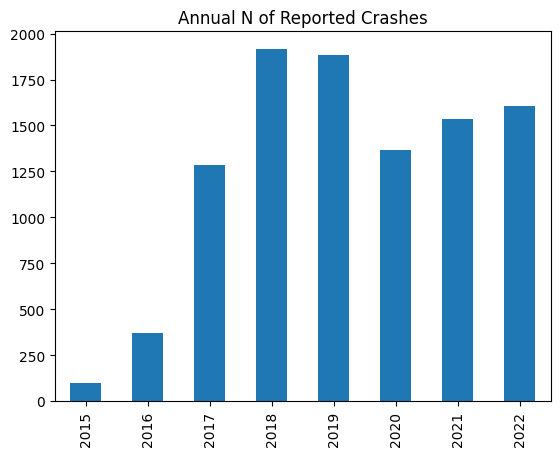

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline 
crashes['crash_year'].value_counts().sort_index().plot.bar(title='Annual N of Reported Crashes')

Hard to know how to interpret this. The dataset was created in October 2017 (https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if), so it's likely that the data from before January 2018 is not recorded in the same fashion. Let's dump the pre-2018 data from our analysis. . . 

In [27]:
len(crashes[crashes['crash_year']<2018])

1755

So we're going to dump roughly 1700 records.

In [28]:
crashes = crashes[crashes['crash_year']>2017]
len(crashes)

8308

<AxesSubplot: title={'center': 'Annual N of Reported Crashes'}>

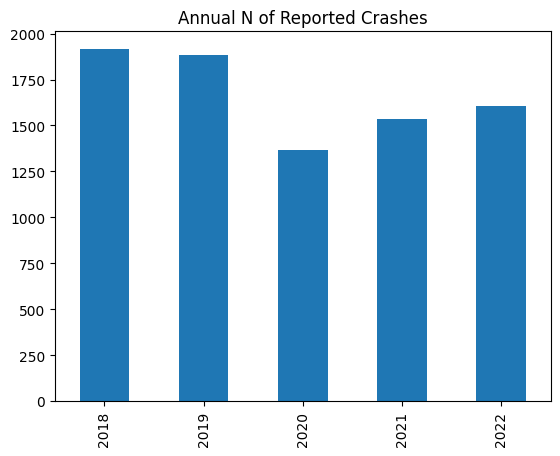

In [29]:
crashes['crash_year'].value_counts().sort_index().plot.bar(title='Annual N of Reported Crashes')

This graph shows that there were significantly fewer crashes reported in 2020 than in the two years prior. 2021 saw an increase, but not to the prior levels.

Let's break it out by month, so we can compare what's going on annually . . 

<AxesSubplot: title={'center': 'Bicycle crashes by Month'}>

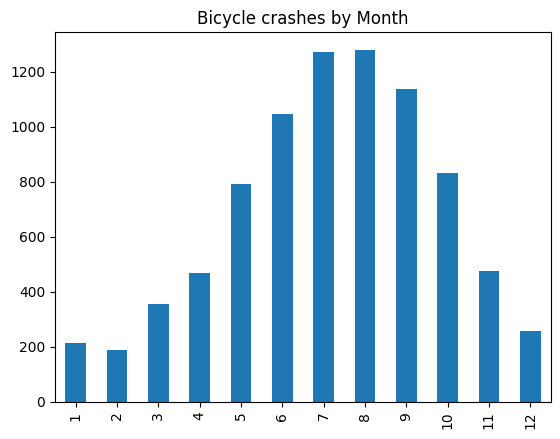

In [30]:
crashes['crash_month'].value_counts().sort_index().plot.bar(title='Bicycle crashes by Month')

To do this, we can use a pivot table to summarize the data, annually and by month.

In a lot of records (>2000!), the "injuries_total" is zero, so it's better to count them then to sum them!

In [31]:
crashes_pivoted = crashes.pivot_table(index = 'crash_month',
    columns = 'crash_year', 
    values = 'injuries_total',
    aggfunc = 'count'
    )

In [32]:
crashes_pivoted

crash_year,2018,2019,2020,2021,2022
crash_month,,,,,
1,57.0,44.0,46.0,38.0,28.0
2,45.0,45.0,51.0,14.0,32.0
3,76.0,76.0,55.0,70.0,76.0
4,103.0,126.0,36.0,104.0,100.0
5,216.0,158.0,90.0,144.0,182.0
6,235.0,219.0,161.0,198.0,234.0
7,289.0,294.0,227.0,229.0,233.0
8,304.0,291.0,243.0,213.0,229.0
9,253.0,257.0,191.0,203.0,233.0


Text(0.5, 0, 'Month of Year')

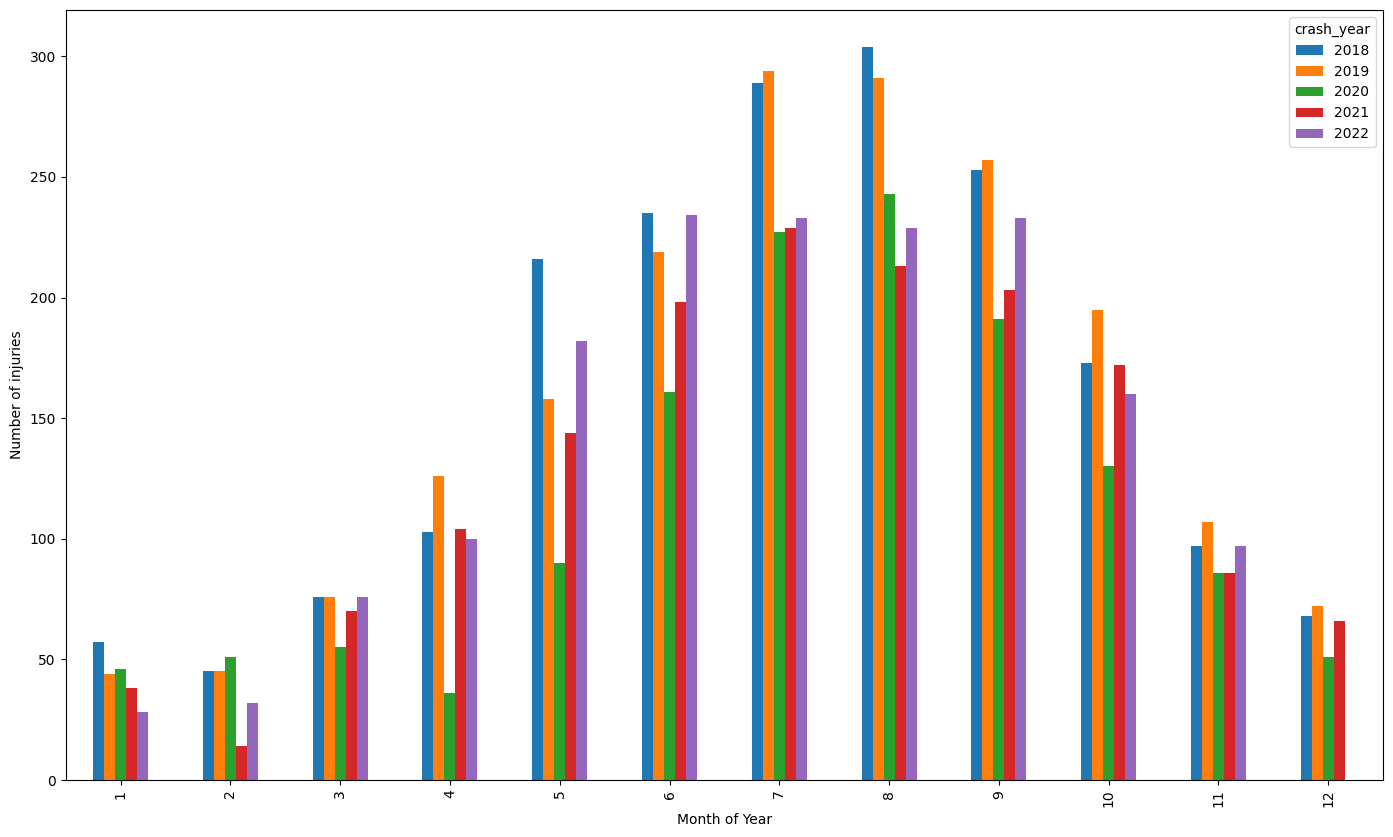

In [33]:
crashes_pivoted.plot(kind ='bar',figsize=(17,10))
plt.ylabel('Number of injuries')
plt.xlabel('Month of Year')


This graph shows the effects of Covid on the accidents reporting starkly.

Recall that in Jan and Feb, Covid was mostly seen as a foreign problem, first in China, then in Europe. On March 13, President Trump declared a nationwide emergency and states began to shutdown schools and businesses. Some states began to roll these restrictions back as early as late April, but Chicago continued to have strong restrictions throughout 2020. (https://www.cdc.gov/museum/timeline/covid19.html)

This timeline is reflected in the graph above. In Jan and Feb, the N reported in 2020 was very similar to the figures from 2018 and 2019. In March, the number dips and in April and May plummets. 

Bike accident reports are not evenly distributed across the city. Rather, they tend to be clustered in certain police beats. Let's examine this.

<AxesSubplot: title={'center': 'Pct of reports by police beat'}>

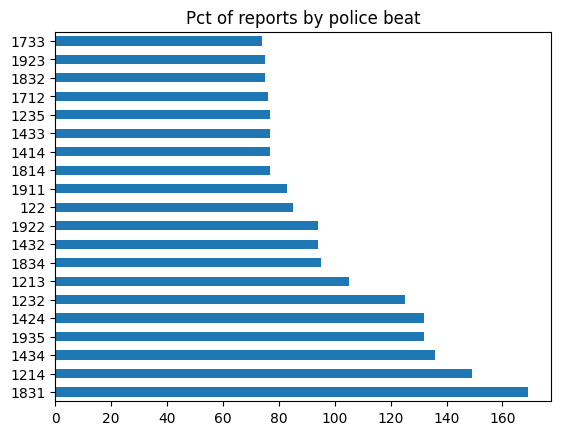

In [34]:
crashes['beat_of_occurrence'].value_counts().head(20).plot.barh(title='Pct of reports by police beat')

Its clear that 1831 and 1213 are far ahead of some of the other beats. Does this vary by year? Again, we can look at this with a pivot table.

In [35]:
beats_pivoted = crashes.pivot_table(index = 'beat_of_occurrence',
    columns = 'crash_year', 
    values = 'injuries_total',
    aggfunc = 'count',
    margins = True, margins_name='Total'
    )

In [36]:
beats_pivoted

crash_year,2018,2019,2020,2021,2022,Total
beat_of_occurrence,,,,,,
111,16.0,10.0,1.0,10.0,13.0,50
112,8.0,10.0,1.0,11.0,7.0,37
113,3.0,4.0,5.0,5.0,4.0,21
114,13.0,16.0,12.0,15.0,10.0,66
121,16.0,19.0,4.0,13.0,7.0,59
...,...,...,...,...,...,...
2532,1.0,2.0,2.0,NaN,2.0,7
2533,7.0,7.0,4.0,11.0,7.0,36
2534,6.0,9.0,4.0,8.0,8.0,35


In [37]:
bp_sorted = beats_pivoted.sort_values(by=('Total'),ascending=False)

<AxesSubplot: ylabel='beat_of_occurrence'>

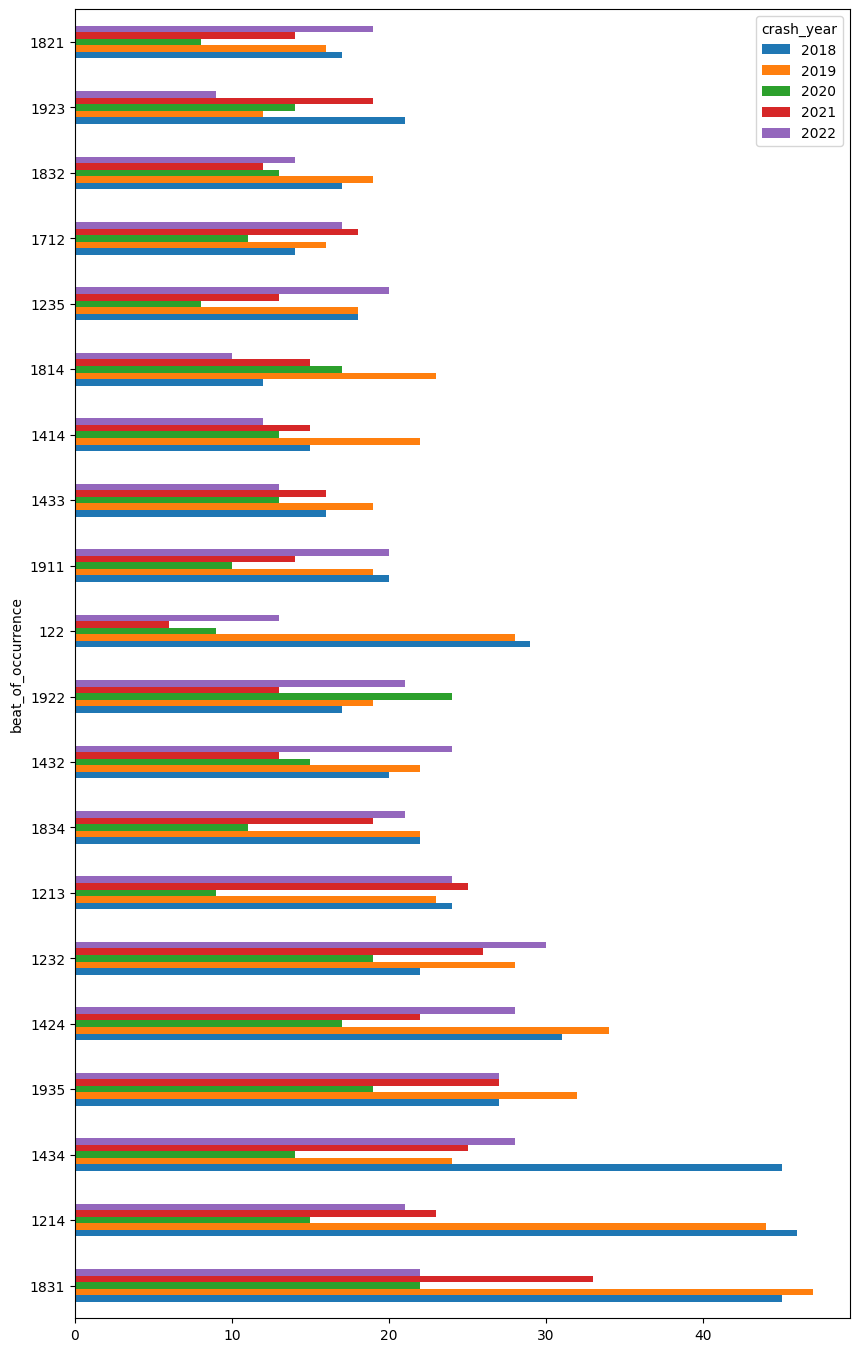

In [38]:
bp_sorted.iloc[1:21,0:5].plot(kind ='barh',figsize=(10,17))

> How does the time of day / weather affect crashes?<br> Are the police accurate in reporting weather conditions?

Let's look at 2021 to examine these questions.

In [39]:
crash21 = crashes[crashes['crash_year'] == 2021]

In [40]:
crash21.head(3)

,crash_record_id,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,statements_taken_i,rd_no,crash_date_est_i,private_property_i,photos_taken_i,work_zone_i,work_zone_type,workers_present_i,lane_cnt,crash_year
1604,4603435fbb4ef5d45c0d805c3e9aa5558a311a140a737e...,2021-12-31 13:46:00,30,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,PEDALCYCLIST,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,NaN,JE494049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1605,38459767b9b1a9bc1faed4a942998a04b6e29aa369541f...,2021-12-30 16:30:00,30,UNKNOWN,UNKNOWN,CLEAR,UNKNOWN,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,NaN,JE493188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1606,39504218c0295e46e36c845c09dea92af78a1a096c59ca...,2021-12-29 14:28:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,...,NaN,JE492056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021


In [41]:
crash21['statements_taken_i'].value_counts()

Y    42
N     4
Name: statements_taken_i, dtype: int64

In [43]:
pd.options.display.max_rows = 600
pd.options.display.max_colwidth = 400

In [45]:
crash21[crash21['statements_taken_i'] == "Y"].head(5)

,crash_record_id,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,statements_taken_i,rd_no,crash_date_est_i,private_property_i,photos_taken_i,work_zone_i,work_zone_type,workers_present_i,lane_cnt,crash_year
1640,53531e4027c00300354e3cb66d57bea2e36c7ef66b40643f4c197fd3ed1d4657f9434b15b8465ebc963ef4d1bd883c4faedb13fbf8527d54199e969d0da01af9,2021-12-10 10:20:00,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT ON GRADE,...,Y,JE472385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1647,ecd4180e2569076913cf4d1eddd7d3030b76474e5c38c581dcda4c56e3d09f86805d58674761fce621bc4dbbeeda3e395b8691ce7cf0d350f1ea4e73239534f3,2021-12-07 16:49:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,T-INTERSECTION,STRAIGHT AND LEVEL,...,Y,JE469591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1670,905a01840212a61de466903eadc80b72113a6f418e3265a624a6191f0cd5233fd320405054486761a5ecbfaaf0f97bffd58269555d5be642243d8ef2ceba69e0,2021-11-30 19:09:00,25,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,Y,JE461767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1762,7dbaa670b350388c5b2a67c8c84b1e203ae8f7ff0ce55e7da89ea18e36188cabee2a6cfad8f6492fb302e9ea5bc47f866a33dd8ad793abf72fe73bed731e372a,2021-10-31 11:00:00,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,Y,JE428872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1763,aeae6291505dbac1a9ffde241d7cedb174268286719e7af6ebc99d4c944ae993e3252710207f315d9d72299059811986fa2f40b8b73fdbfc1e4af4fa4330d2b6,2021-10-31 10:45:00,20,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,Y,JE428868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021


In [47]:
headings = ['lighting_condition','weather_condition','posted_speed_limit','alignment','rd_no','photos_taken_i']
for head in headings:
    print(crash21[head].value_counts())

DAYLIGHT                  1113
DARKNESS, LIGHTED ROAD     291
DUSK                        48
DARKNESS                    38
UNKNOWN                     24
DAWN                        23
Name: lighting_condition, dtype: int64
CLEAR                    1344
RAIN                      101
UNKNOWN                    44
CLOUDY/OVERCAST            39
SNOW                        5
FREEZING RAIN/DRIZZLE       3
OTHER                       1
Name: weather_condition, dtype: int64
30    1220
25     114
35      87
20      56
15      38
10      12
0        4
45       2
24       1
40       1
5        1
2        1
Name: posted_speed_limit, dtype: int64
STRAIGHT AND LEVEL       1504
STRAIGHT ON GRADE          25
STRAIGHT ON HILLCREST       5
CURVE, LEVEL                3
Name: alignment, dtype: int64
JE494049    1
JE317804    1
JE272503    1
JE273231    1
JE273440    1
           ..
JE360408    1
JE360558    1
JE360641    1
JE360823    1
JE100653    1
Name: rd_no, Length: 1537, dtype: int64
Y    12
N   

In [49]:
rainy = crash21[crash21['weather_condition']=='RAIN']
rainy.head(5)

,crash_record_id,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,statements_taken_i,rd_no,crash_date_est_i,private_property_i,photos_taken_i,work_zone_i,work_zone_type,workers_present_i,lane_cnt,crash_year
1604,4603435fbb4ef5d45c0d805c3e9aa5558a311a140a737e37aa56d4f70ea0161f8f2e187270d33f36070c6a1b0f0c26401d0f0ad8b3f9dae797f8041f754d6297,2021-12-31 13:46:00,30,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,PEDALCYCLIST,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,NaN,JE494049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1608,69d7b94e1fedc18c90e4f82830cbdc66229d9d924add0eabab78552736c745b177313a182a8757262c0c6dc2447e69aae11136c5ac276163eafc0b844ffa7559,2021-12-27 09:10:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,...,NaN,JE489861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1625,0ee18d13dfcd5d09e35be73fb5e070ba623d33355224fbb23fef590805a57653372bb79ac7be359e273d69cf66af591941e70ad2751e35d106759eba9a5f92bf,2021-12-14 21:00:00,20,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,NaN,JE477739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1638,8d272e0b17c3c0f52e34ef91eb64d94a6847f2375e35ad506c0f152366b171fda437a4e9a669666db0cc3824b1ea08dd0ea67e416c094964ffa3a869fb5bb135,2021-12-10 19:26:00,35,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,NaN,JE473100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
1639,b518490c791bf6b75a8958b503a2999fd824ba8fabdba5305d7e95e51e59fa43e08ce608f87b4395dbebd1165662a310f12da2040f7a50ee2fd240cb52b9e1bf,2021-12-10 18:30:00,35,TRAFFIC SIGNAL,NO CONTROLS,RAIN,DARKNESS,PEDALCYCLIST,ONE-WAY,STRAIGHT AND LEVEL,...,NaN,JE476355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021


In [52]:
rainy['location'].head(3)

1604    {'type': 'Point', 'coordinates': [-87.578269718478, 41.766335621716]}
1608    {'type': 'Point', 'coordinates': [-87.649787129108, 41.779581012899]}
1625    {'type': 'Point', 'coordinates': [-87.766869741854, 41.918941942487]}
Name: location, dtype: object

In [58]:
rainy['latitude'].head(1)

1604    41.766336
Name: latitude, dtype: float64

In [123]:
def weatherLookup(lat,lon,dateTime,APIkey=weatherAPIkey):
    import urllib
    import json
    latS, lonS  = str(lat), str(lon)
    dateTimeS = dateTime.strftime('%Y-%m-%dT%H:%M:%S')
    ApiQuery = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'+\
            latS+'%2C'+lonS+'/'+dateTimeS+'?unitGroup=us&key='+APIkey+'&include=current&contentType=json'
    try: 
        with urllib.request.urlopen(ApiQuery) as response:
            html = response.read()
    except urllib.error.HTTPError  as e:
        ErrorInfo= e.read().decode() 
        print('Error code: ', e.code, ErrorInfo)
        sys.exit()
    except  urllib.error.URLError as e:
        ErrorInfo= e.read().decode() 
        print('Error code: ', e.code,ErrorInfo)
        sys.exit()

    weather = json.loads(html.decode('utf-8'))
    return weather['currentConditions']['temp'], weather['currentConditions']['conditions'], weather['currentConditions']['preciptype']


In [60]:
print(weatherLookup(str(-87.578269718478),str(-87.578269718478),'2021-12-31','13:46:00',weatherAPIkey))

(-8.4, 'Overcast', None)


In [70]:
#crashes['crash_year'] = crashes['crash_date'].dt.year
rainy['crash_date'].dt.strftime('%Y-%m-%dT%H:%M:%S').head(1)

1604    2021-12-31T13:46:00
Name: crash_date, dtype: object

In [124]:
test['wCondit'] = test.apply(lambda test: weatherLookup(test.latitude, test.longitude, test.crash_date,weatherAPIkey),axis = 1)


In [ ]:
test[['wTemp','wCond','wPrecip']] = 
    [weatherLookup(*a) for a in tuple(zip(test['latitude'],test['longitude'],test['crash_date']))]

test

In [130]:
crash21.columns

Index(['crash_record_id', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'damage', 'date_police_notified',
       'prim_contributory_cause', 'sec_contributory_cause', 'street_no',
       'street_direction', 'street_name', 'beat_of_occurrence', 'dooring_i',
       'num_units', 'most_severe_injury', 'injuries_total', 'injuries_fatal',
       'injuries_incapacitating', 'injuries_non_incapacitating',
       'injuries_reported_not_evident', 'injuries_no_indication',
       'injuries_unknown', 'crash_hour', 'crash_day_of_week', 'crash_month',
       'latitude', 'longitude', 'location', 'intersection_related_i',
       'hit_and_run_i', 'statements_taken_i', 'rd_no', 'crash_date_est_i',
       'private_property_i', 'photos_taken_i', 'work_zone_i', 'work_zone_type',
      

In [131]:
crash21['most_severe_injury'].value_counts().sort_index()

FATAL                         7
INCAPACITATING INJURY       146
NO INDICATION OF INJURY     403
NONINCAPACITATING INJURY    810
REPORTED, NOT EVIDENT       171
Name: most_severe_injury, dtype: int64

In [132]:
badInjury = crash21[crash21['most_severe_injury']=='INCAPACITATING INJURY']

In [133]:
badInjury['weather_condition'].value_counts()

CLEAR              126
RAIN                11
UNKNOWN              4
CLOUDY/OVERCAST      3
SNOW                 2
Name: weather_condition, dtype: int64

In [135]:
badInjury[['wTemp','wCond','wPrecip']] = \
    [weatherLookup(*a) for a in tuple(zip(badInjury['latitude'],badInjury['longitude'],badInjury['crash_date']))]

/tmp/ipykernel_635984/681675443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  badInjury[['wTemp','wCond','wPrecip']] = \
/tmp/ipykernel_635984/681675443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  badInjury[['wTemp','wCond','wPrecip']] = \
/tmp/ipykernel_635984/681675443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [137]:
badInjury.sample(10)

,crash_record_id,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,private_property_i,photos_taken_i,work_zone_i,work_zone_type,workers_present_i,lane_cnt,crash_year,wTemp,wCond,wPrecip
1911,c19ce8fe678b1693e27a4f2cf1b5f2efffa16f594ce21227c3aed84d5a145a7b27379e084f143b3ad36709b00c964b529d4b1baf125a80713c66465a7dfcc503,2021-10-04 19:44:00,30,TRAFFIC SIGNAL,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,67.3,Overcast,None
3085,967783f483ead199e53dccee44b2dd5b1ef42a6251b129d49b9caa66ddb05b484114809526f7e3e4c3ed6aa69151ffa5dddf935e4e056cb88d1e1010f7e70d60,2021-03-02 15:55:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDALCYCLIST,FOUR WAY,STRAIGHT AND LEVEL,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,42.0,Clear,None
1848,f6198c266f65265e6868d066cd4f29b1ff76f2e18f4da95f3bf3053f3af9521b94e8e09aa336b118a0cc1efcc91ec8d3362498fe882ef9ddd03c0124bcb86025,2021-10-16 15:00:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,59.3,Partially cloudy,None
1657,070c71bfc229a6b429868790eb90a890b25941b5ab8396a4b4ffb0992980949dacce76860d9d1f0d8dc41068e471934abcdbc6dc3ea9b312368a8284508fdee5,2021-12-02 17:23:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,PEDALCYCLIST,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,50.0,Partially cloudy,None
1814,f5556a1237866e0c5c8e38f3bafd287f7c7c70f64a424a6fb11bb2a4516fcf75188c554bf19b17fb8b15ba5197f2ea55f885da658960897b55308a8ff60d3d90,2021-10-21 14:35:00,30,NO CONTROLS,NO CONTROLS,CLOUDY/OVERCAST,DAYLIGHT,PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,51.0,Overcast,None
2147,76551113b651c6743b16a596e469859699682d4d209356356c3560c9048672557171d8cd74e7955b92d05f751720e133f8247b978383b0ca9f5d884d7a04ff40,2021-08-29 15:15:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,86.9,Partially cloudy,None
1809,f270be9716c4e236805651c1dcef7caeb0fe5f700b9b568cfa40dbf2b1eb829c0f326dee1eb6655f294c72c0edd60e6a69be118844ee3772b18e68e481c8394a,2021-10-22 18:46:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,52.4,Overcast,None
1874,d9625dcdc791d0091982d7395c457c81d220c3215dd9cb93bf0e5e9edb3ac79c8d768b697d53237f87aa317fecb565b637c6618a51a6bcfb56060cd7384f7cb7,2021-10-12 19:30:00,25,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,63.4,Partially cloudy,None
1769,28319bf0472112ff33380b34d2a762f8d7bf0914edb5cc0807979ce447063adc491c401fdd8a753ed81672517927ad17eb522e8389dd8e745a28a18d5b4471ff,2021-10-30 09:15:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,53.2,Overcast,None
2621,094ca7525dfa7644d88cfe39dd1d6fe01423e6d530a7ce991ff62c528b9343015143fd43c5c66ad6f5cbff3341c4c5fbf43ed7da8a0446c89cdf0a7689270d9f,2021-06-23 09:20:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,65.8,Overcast,None


In [145]:
crash21['weather_condition'].value_counts(normalize=True)

CLEAR                    0.874431
RAIN                     0.065712
UNKNOWN                  0.028627
CLOUDY/OVERCAST          0.025374
SNOW                     0.003253
FREEZING RAIN/DRIZZLE    0.001952
OTHER                    0.000651
Name: weather_condition, dtype: float64

In [146]:
crash21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1537 entries, 1604 to 3140
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   crash_record_id                1537 non-null   object        
 1   crash_date                     1537 non-null   datetime64[ns]
 2   posted_speed_limit             1537 non-null   int64         
 3   traffic_control_device         1537 non-null   object        
 4   device_condition               1537 non-null   object        
 5   weather_condition              1537 non-null   object        
 6   lighting_condition             1537 non-null   object        
 7   first_crash_type               1537 non-null   object        
 8   trafficway_type                1537 non-null   object        
 9   alignment                      1537 non-null   object        
 10  roadway_surface_cond           1537 non-null   object        
 11  road_defect   

In [147]:
crash21['latitude'].mean()

41.89529666462941

In [148]:
crash21['longitude'].mean()

-87.67682552741503

In [150]:
1000 / 6



166.66666666666666